In [47]:
import os
from snorkel.labeling import labeling_function
import pandas as pd
from snorkel.labeling import PandasLFApplier
from snorkel.labeling import LFAnalysis
from snorkel.analysis import get_label_buckets
from snorkel.labeling.model import MajorityLabelVoter
from snorkel.labeling.model import LabelModel
from snorkel.labeling import filter_unlabeled_dataframe
from snorkel.utils import probs_to_preds
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import StringTensorType


%matplotlib inline

In [48]:
# Turn off TensorFlow logging messages
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

# For reproducibility
os.environ["PYTHONHASHSEED"] = "0"

In [49]:
df = pd.read_excel('/Users/marcusturewicz/Documents/tweets.xlsx', usecols=['Label', 'Text', 'Language', 'Hashtags', 'URLs', 'Mentions', 'Media Type'])

df_test = df[(df['Label'] == 1) | (df['Label'] == 0)]
df_train = df[(df['Label'] == -1)]

Y_test = df_test['Label'].values

In [50]:
print(len(df))

6351


In [51]:
df_train

,Label,Text,Language,URLs,Hashtags,Mentions,Media Type
0,-1,RT @ApTrainings : #aptrainings #Webinar #educ...,und,NaN,34,0,photo
1,-1,RT @ZevsCrypto : #Program #Coding #Crypto #UNI...,en,https://twitter.com/ZevsCrypto/status/14298324...,34,0,NaN
2,-1,RT @ZevsCrypto : #Program #Coding #Crypto #UNI...,en,https://twitter.com/ZevsCrypto/status/14297114...,34,0,NaN
3,-1,RT @ZevsCrypto : #Program #Coding #Crypto #UNI...,en,https://twitter.com/ZevsCrypto/status/14297101...,34,0,NaN
4,-1,RT @Me_llaman_jota : Hi 😁\n#RTXOn #coding #jav...,und,NaN,33,0,photo
...,...,...,...,...,...,...,...
6329,-1,RT @MircoVanini : Performance Improvements in ...,en,https://devblogs.microsoft.com/dotnet/performa...,1,0,NaN
6330,-1,RT @MircoVanini : Understanding the cost of C#...,en,https://devblogs.microsoft.com/dotnet/understa...,1,0,NaN
6348,-1,RT @ElalamyOla : Create microservices with .NE...,en,http://ASP.NET https://docs.microsoft.com/en-u...,0,0,NaN
6349,-1,RT @Wintellect : .NET 6 is on [the way](https:...,en,https://devblogs.microsoft.com/dotnet/announci...,0,0,NaN


In [52]:
df[['Text', 'Hashtags']].sample(50, random_state=2)

,Text,Hashtags
5013,"RT @markrendle : OK, live now on https://t.co/...",2
5964,RT @StackDevJobs : Security &amp; DevOps Engin...,1
4058,RT @hasdid : #NetInsight #DotNet #Automated | ...,3
3773,RT @brunohilden : Learn how to create your own...,4
3284,RT @ArctionLtd : The newest LightningChart .NE...,5
2184,RT @dotnetforall : Top 20 C# interview questio...,7
275,RT @TeamPatriot007 : #include&lt;stdio.h&gt;\n...,25
1947,RT @developrec : Python is battling for pole p...,8
15,RT @ZevsCrypto : #shibainu $UFO #Shibarmy #cry...,32
1547,RT @sarrawy2016 : Blazor (ASP.NET-Core) - Crea...,11


In [53]:
ABSTAIN = -1
HAM = 0
SPAM = 1

In [54]:
@labeling_function()
def hiring(x):
    return SPAM if "hiring" in x['Text'].lower() else ABSTAIN

@labeling_function()
def hire(x):
    return SPAM if "hire" in x['Text'].lower() else ABSTAIN    

@labeling_function()
def job(x):
    return SPAM if "job" in x['Text'].lower() else ABSTAIN

@labeling_function()
def career(x):
    return SPAM if "career" in x['Text'].lower() else ABSTAIN

@labeling_function()
def offer(x):
    return SPAM if "offer" in x['Text'].lower() else ABSTAIN

@labeling_function()
def candidate(x):
    return SPAM if "candidate" in x['Text'].lower() else ABSTAIN       

@labeling_function()
def money(x):
    return SPAM if "$" in x['Text'] else ABSTAIN

@labeling_function()
def percent(x):
    return SPAM if "%" in x['Text'] else ABSTAIN

@labeling_function()
def exclaim(x):
    return SPAM if "!" in x['Text'] else ABSTAIN     

@labeling_function()
def links(x):
    return SPAM if x['Text'].count('http') > 2 else ABSTAIN       

@labeling_function()
def visit(x):
    return SPAM if "visit" in x['Text'].lower() else ABSTAIN     

@labeling_function()
def subscribe(x):
    return SPAM if "subscribe" in x['Text'].lower() else ABSTAIN

@labeling_function()
def firewall(x):
    return SPAM if "firewall" in x['Text'].lower() else ABSTAIN    

@labeling_function()
def blockchain(x):
    return SPAM if "blockchain" in x['Text'].lower() else ABSTAIN       

@labeling_function()
def crypto(x):
    return SPAM if "crypto" in x['Text'].lower() else ABSTAIN           

@labeling_function()
def buy(x):
    return SPAM if "buy" in x['Text'].lower() else ABSTAIN

@labeling_function()
def free(x):
    return SPAM if "free" in x['Text'].lower() else ABSTAIN

@labeling_function()
def sale(x):
    return SPAM if 'sale' in x['Text'].lower() else ABSTAIN      

@labeling_function()
def today(x):
    return SPAM if "today" in x['Text'].lower() else ABSTAIN     

@labeling_function()
def hashtags(x):
    return SPAM if x['Hashtags'] > 8 else ABSTAIN   

@labeling_function()
def minimal_hashtags(x):
    return HAM if x['Hashtags'] < 5 else ABSTAIN       

@labeling_function()
def mentions(x):
    return SPAM if x['Mentions'] > 2 else ABSTAIN

@labeling_function()
def lang_und(x):
    return SPAM if x['Language'] == 'und' else ABSTAIN 

@labeling_function()
def net(x):
    return HAM if ' .net ' in x['Text'].lower() else ABSTAIN

@labeling_function()
def nuget(x):
    return HAM if 'nuget' in x['Text'].lower() else ABSTAIN       

@labeling_function()
def at_dotnet(x):
    return HAM if x['Text'].startswith('RT @dotnet') else ABSTAIN    

In [55]:
lfs = [hiring, hire, job, career, offer, candidate, money, percent, exclaim, visit, subscribe, firewall, buy, free, today, blockchain, crypto, hashtags, sale, mentions, lang_und, minimal_hashtags, net, nuget, at_dotnet]

print(len(lfs))

applier = PandasLFApplier(lfs=lfs)
L_train = applier.apply(df=df_train)

25


100%|██████████| 6138/6138 [00:02<00:00, 2951.97it/s]


In [56]:
L_train

array([[-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       ...,
       [-1, -1, -1, ...,  0, -1, -1],
       [-1, -1, -1, ...,  0, -1, -1],
       [-1, -1, -1, ...,  0, -1, -1]])

In [57]:
LFAnalysis(L=L_train, lfs=lfs).lf_summary()

,j,Polarity,Coverage,Overlaps,Conflicts
hiring,0,[1],0.028185,0.027533,0.012708
hire,1,[1],0.006680,0.006680,0.001955
job,2,[1],0.074780,0.071359,0.027533
career,3,[1],0.017758,0.015966,0.003747
offer,4,[1],0.005702,0.005213,0.001629
candidate,5,[1],0.013848,0.013359,0.002770
money,6,[1],0.021668,0.021342,0.003584
percent,7,[1],0.004562,0.004399,0.001955
exclaim,8,[1],0.161779,0.144184,0.105083
visit,9,[1],0.019062,0.013359,0.009775


In [58]:
df_train.iloc[L_train[:, 1] == SPAM].sample(10, random_state=1)[['Text', 'Hashtags', 'Label']]

,Text,Hashtags,Label
1094,RT @unicorntalents : Hire the best C# programm...,17,-1
996,RT @HirectApp : .@Prostooservices is #Hiring o...,18,-1
2059,RT @JobHookup4U : Senior C# Developer - New Yo...,8,-1
3781,RT @SoftwaredevIn : Need a #Dotnet programmer ...,4,-1
1864,RT @Julieeeee06 : hiring kami!!!!\n\nDM mo sak...,9,-1
2104,RT @JobHookup4U : Senior C# Developer - New Yo...,8,-1
1889,RT @Katheri01147964 : #Hire #dotNET #Developer...,8,-1
3188,RT @HindleyWesley : WHY HIRE A DEDICATED #ASPD...,5,-1
2118,RT @JobHookup4U : Senior C# Developer - New Yo...,8,-1
2056,RT @OfficialHaritha : Hire .net Programmer\nht...,8,-1


In [59]:
buckets = get_label_buckets(L_train[:, 0], L_train[:, 1])
df_train.iloc[buckets[(ABSTAIN, SPAM)]].sample(10, random_state=1)

,Label,Text,Language,URLs,Hashtags,Mentions,Media Type
3399,-1,RT @FortuneInfosys : Are you looking for an #A...,en,https://fortuneinfosys.com/contact-us/,5,0,photo
2104,-1,RT @JobHookup4U : Senior C# Developer - New Yo...,en,NaN,8,0,NaN
2118,-1,RT @JobHookup4U : Senior C# Developer - New Yo...,en,NaN,8,0,NaN
2813,-1,RT @SapphireSoftwa : Check out the key reasons...,en,https://bit.ly/AspdotNetDevelopmentService,6,0,photo
2076,-1,RT @JobHookup4U : Senior C# Developer - New Yo...,en,NaN,8,0,NaN
1342,-1,RT @XSstudios : Hire the best .NET developer f...,en,http://www.xsstudios.com,14,0,photo
3185,-1,RT @AmeliaS26018837 : ↪ Hire .NET Core Develop...,en,https://www.bacancytechnology.com/dot-net-core...,5,0,NaN
2051,-1,RT @JobHookup4U : Senior C# Developer - New Yo...,en,NaN,8,0,NaN
3007,-1,RT @Adriasolutions : Are you a talented .Net D...,en,http://ow.ly/pRXi50FRYkp,6,0,video
1411,-1,RT @XSstudios : Hire the best .NET developer f...,en,http://www.xsstudios.com,13,0,photo


In [60]:
L_test = applier.apply(df=df_test)

100%|██████████| 213/213 [00:00<00:00, 3556.29it/s]


In [61]:
LFAnalysis(L=L_train, lfs=lfs).lf_summary()

,j,Polarity,Coverage,Overlaps,Conflicts
hiring,0,[1],0.028185,0.027533,0.012708
hire,1,[1],0.006680,0.006680,0.001955
job,2,[1],0.074780,0.071359,0.027533
career,3,[1],0.017758,0.015966,0.003747
offer,4,[1],0.005702,0.005213,0.001629
candidate,5,[1],0.013848,0.013359,0.002770
money,6,[1],0.021668,0.021342,0.003584
percent,7,[1],0.004562,0.004399,0.001955
exclaim,8,[1],0.161779,0.144184,0.105083
visit,9,[1],0.019062,0.013359,0.009775


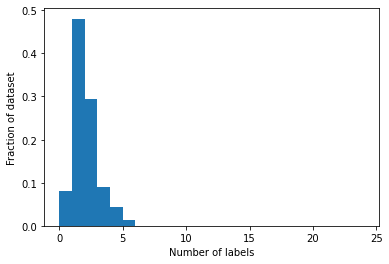

In [62]:
def plot_label_frequency(L):
    plt.hist((L != ABSTAIN).sum(axis=1), density=True, bins=range(L.shape[1]))
    plt.xlabel("Number of labels")
    plt.ylabel("Fraction of dataset")
    plt.show()


plot_label_frequency(L_train)

In [63]:
majority_model = MajorityLabelVoter()
majority_model.predict(L=L_train)

array([1, 1, 1, ..., 0, 0, 0])

In [64]:
label_model = LabelModel(cardinality=2, verbose=True)
label_model.fit(L_train=L_train, n_epochs=500, log_freq=100, seed=123)

In [65]:
majority_acc = majority_model.score(L=L_test, Y=Y_test, tie_break_policy="random")[
    "accuracy"
]
print(f"{'Majority Vote Accuracy:':<25} {majority_acc * 100:.1f}%")

label_model_acc = label_model.score(L=L_test, Y=Y_test, tie_break_policy="random")[
    "accuracy"
]
print(f"{'Label Model Accuracy:':<25} {label_model_acc * 100:.1f}%")

Majority Vote Accuracy:   79.3%
Label Model Accuracy:     84.5%


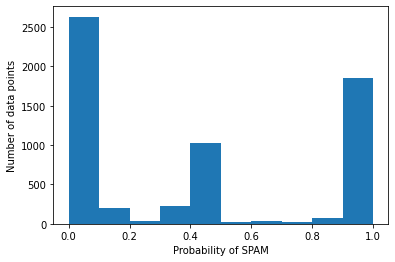

In [66]:
def plot_probabilities_histogram(Y):
    plt.hist(Y, bins=10)
    plt.xlabel("Probability of SPAM")
    plt.ylabel("Number of data points")
    plt.show()


probs_train = label_model.predict_proba(L=L_train)
plot_probabilities_histogram(probs_train[:, SPAM])

In [67]:
df_train_filtered, probs_train_filtered = filter_unlabeled_dataframe(
    X=df_train, y=probs_train, L=L_train
)

In [68]:
vectorizer = CountVectorizer(ngram_range=(1, 5))

In [69]:
X_train = df_train_filtered['Text'].tolist()
X_test = df_test['Text'].tolist()

In [70]:
preds_train_filtered = probs_to_preds(probs=probs_train_filtered)

In [71]:
sklearn_model = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)

In [72]:
pipe = Pipeline([("vectorizer", vectorizer), ("model", sklearn_model)])
pipe.fit(X=X_train, y=preds_train_filtered)

Pipeline(steps=[('vectorizer', CountVectorizer(ngram_range=(1, 5))),
                ('model',
                 GradientBoostingClassifier(learning_rate=1.0, max_depth=1,
                                            random_state=0))])

In [73]:
print(f"Test Accuracy: {pipe.score(X=X_test, y=Y_test) * 100:.1f}%")

Test Accuracy: 85.0%


In [74]:
Y_preds = pipe.predict(X=X_test)

print(classification_report(Y_test, Y_preds))


              precision    recall  f1-score   support

           0       0.81      0.92      0.86       107
           1       0.90      0.78      0.84       106

    accuracy                           0.85       213
   macro avg       0.86      0.85      0.85       213
weighted avg       0.86      0.85      0.85       213



In [75]:
test_text = """#include<stdio.h>
#include<conio.h>
void main()
{
printf{"#GaneshChaturthi #DBoss};
getch()
#forex #bot #AI #Website #CodeNewbie #women #hacker #flutter #python #100DaysOfCode #ad #WomenWhoCode #tech #css  #cybersecurity #Blockchain #DataScience #infosec #dotnet #ClimateAction"""

pipe.predict(X=X_test)[0]

1

In [76]:
model_onnx = convert_sklearn(pipe, initial_types=[("input", StringTensorType([None, 1]))])

/Users/marcusturewicz/opt/anaconda3/envs/spam-filter/lib/python3.8/site-packages/skl2onnx/operator_converters/text_vectoriser.py:184: UserWarning: Converter for TfidfVectorizer will use scikit-learn regular expression by default in version 1.6.
  warnings.warn("Converter for TfidfVectorizer will use "
/Users/marcusturewicz/opt/anaconda3/envs/spam-filter/lib/python3.8/site-packages/skl2onnx/common/_container.py:607: UserWarning: Unable to find operator 'Tokenizer' in domain 'com.microsoft' in ONNX, op_version is forced to 1.
  warnings.warn(


In [77]:
with open("../DotNetTwitterBot/spam_filter.onnx", "wb") as f:
    f.write(model_onnx.SerializeToString())